In [1]:
from aeon.datasets import load_classification
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from laplace_hdc_helper import load_dataset
from laplace_hdc_classifier_1d import train_hdc_classifier, test_hdc_classifier
from laplace_hdc_encoder_1d import hdc_encoder
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
from scipy.io import savemat, loadmat


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset_name = 'Epilepsy'
try:
    NHDC = loadmat(f'../{dataset_name}_nHD.mat')[f'{dataset_name}_nHD']
except:
    NHDC = range(1000, 5500, 500)
    
NHDC

array([[ 5000.,  7000.,  5000.],
       [ 5000.,  8000.,  6000.],
       [ 6000.,  9000.,  7000.],
       [ 7000., 11000.,  8000.],
       [ 8000., 12000.,  9000.],
       [ 9000., 13000., 10000.],
       [10000., 15000., 11000.],
       [11000., 16000., 12000.],
       [11000., 17000., 13000.],
       [12000., 18000., 14000.],
       [13000., 20000., 15000.]])

In [3]:
# Load dataset
X_train, y_train, metadata = load_classification(dataset_name, return_metadata=True, split='train')
X_test, y_test = load_classification(dataset_name, split='test')
if X_train.shape[0] < 200:
    if X_test.shape[0] >= 200:
        train_size = (X_train.shape[0] + X_test.shape[0]) * 3/4
        x, y = load_classification(dataset_name)
        X_train, y_train = x[:train_size, :], y[:train_size]
        X_test, y_test = x[train_size:, :], y[train_size:]

In [4]:
input_channels = 1
if X_train.ndim == 3:
    input_channels = X_train.shape[1]
seq_length = X_train.shape[-1]
if y_train.dtype == object or isinstance(y_train[0], str):
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, seq_length))
X_test_scaled = scaler.transform(X_test.reshape(-1, seq_length))

if input_channels == 1:
    X_min = X_train_scaled.min(axis=0)
    X_max = X_train_scaled.max(axis=0)
    
    denom = (X_max - X_min)
    denom[denom == 0] = 1   # avoid division by zero
    
    X_train_norm = (X_train_scaled - X_min) / denom
    X_test_norm  = (X_test_scaled  - X_min) / denom
    
    # Optional: clip to [0,1] just in case
    X_train_norm = np.clip(X_train_norm, 0, 1)
    X_test_norm  = np.clip(X_test_norm, 0, 1)
    X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32).unsqueeze(1).to(device)
    X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32).unsqueeze(1).to(device)
else:
    X_min = X_train.min(axis=0)
    X_max = X_train.max(axis=0)
    
    denom = (X_max - X_min)
    denom[denom == 0] = 1   # avoid division by zero
    
    X_train_norm = (X_train - X_min) / denom
    X_test_norm  = (X_test  - X_min) / denom
    
    # Optional: clip to [0,1] just in case
    X_train_norm = np.clip(X_train_norm, 0, 1)
    X_test_norm  = np.clip(X_test_norm, 0, 1)
    # Multichannel → keep original channels
    X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32).to(device)

    

In [6]:
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

num_classes = len(np.unique(y_train))

In [7]:
X_train.shape, X_test.shape

((137, 3, 206), (138, 3, 206))

lambda = 0.02466578409075737
618


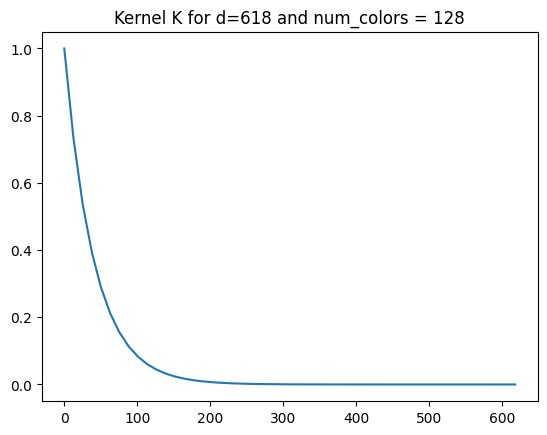

In [8]:
# Determining Lambda from random 1000 samples
bandwidth_parameter = 3 # bandwidth parameter
encoder_mode = 'shift_1d'
classifier_mode="float_sgd"
batch_size = 1024
num_colors = 128

X,  _ = next(iter(DataLoader(train_data, batch_size=1000, shuffle=True)))
X = X.reshape(X.shape[0],-1).cpu()

D = torch.sum(torch.abs(X.unsqueeze(0)-X.unsqueeze(1)),dim=2)
a = torch.median(D.flatten())
lmd = bandwidth_parameter/a
print(f"lambda = {lmd}")

# Define the local kernel
x = np.linspace(0, 1, num=num_colors).reshape(-1, 1)
f = lambda X: 1 - lmd*X
kernel = f(np.abs(x - x.T))

# Visualize the global kernel
d = train_data[0][0].squeeze().numel()
print(d)
S = lambda v: np.exp(-lmd*v)
v = np.linspace(0, d)
plt.plot(v, S(v))
plt.title(f"Kernel K for d={d} and num_colors = {num_colors}")
plt.show()

In [9]:
hyperdims = np.mean(NHDC, axis=1, dtype=int)
hyperdims

array([ 5666,  6333,  7333,  8666,  9666, 10666, 12000, 13000, 13666,
       14666, 16000])

In [10]:
num_workers = 0
pin_memory=False
n_splits = 20
split_size = len(test_data) // n_splits # 10000 // 20 = 500scales = np.arange(0.2, 1.21, 0.1)
print(split_size)
accuracies = np.zeros((len(hyperdims), n_splits))
num_classes=len(np.unique(y_train))
for i, nHDC in enumerate(hyperdims):
    print(f'Hyperdimension: {nHDC} Started --------------')
    # Train
    for split_idx in tqdm(range(n_splits)):
        encoder = hdc_encoder(d, nHDC, kernel, encoder_mode)
        train_hdc = encoder.encode(train_loader)
        train_loader_hdc = DataLoader(train_hdc,batch_size=512,shuffle=True,num_workers=0,pin_memory=False)
        model = train_hdc_classifier(train_loader_hdc, num_classes, mode=classifier_mode, epochs=10)
        # print(f'Encoding Train Data and Training the Model for nHDC={nHDC} finished')
        # Test
        split_hdc = encoder.encode(test_loader)
        split_loader_hdc = DataLoader(
            split_hdc,
            batch_size=64,
            shuffle=True,
            num_workers=0,
            pin_memory=False
        )
        accuracies[i, split_idx] = test_hdc_classifier(model, split_loader_hdc)*100
    print(f'Hyperdimension: {nHDC} Finished. Average Accuracy over {n_splits} rounds: {np.mean(accuracies[i])}, std: {np.std(accuracies[i])}')


6
Hyperdimension: 5666 Started --------------


100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


Hyperdimension: 5666 Finished. Average Accuracy over 20 rounds: 61.9927536231884, std: 5.853327871814738
Hyperdimension: 6333 Started --------------


100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


Hyperdimension: 6333 Finished. Average Accuracy over 20 rounds: 60.94202898550723, std: 5.04599720537788
Hyperdimension: 7333 Started --------------


100%|██████████| 20/20 [00:11<00:00,  1.78it/s]


Hyperdimension: 7333 Finished. Average Accuracy over 20 rounds: 65.43478260869566, std: 6.04584112568584
Hyperdimension: 8666 Started --------------


100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


Hyperdimension: 8666 Finished. Average Accuracy over 20 rounds: 65.79710144927536, std: 6.357018028829365
Hyperdimension: 9666 Started --------------


100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


Hyperdimension: 9666 Finished. Average Accuracy over 20 rounds: 66.15942028985508, std: 6.988528422393877
Hyperdimension: 10666 Started --------------


100%|██████████| 20/20 [00:11<00:00,  1.74it/s]


Hyperdimension: 10666 Finished. Average Accuracy over 20 rounds: 66.55797101449275, std: 5.959126162876462
Hyperdimension: 12000 Started --------------


100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


Hyperdimension: 12000 Finished. Average Accuracy over 20 rounds: 67.2463768115942, std: 5.060026159448142
Hyperdimension: 13000 Started --------------


100%|██████████| 20/20 [00:11<00:00,  1.71it/s]


Hyperdimension: 13000 Finished. Average Accuracy over 20 rounds: 67.8623188405797, std: 4.791795086084959
Hyperdimension: 13666 Started --------------


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Hyperdimension: 13666 Finished. Average Accuracy over 20 rounds: 68.94927536231884, std: 6.35980522133077
Hyperdimension: 14666 Started --------------


100%|██████████| 20/20 [00:11<00:00,  1.68it/s]


Hyperdimension: 14666 Finished. Average Accuracy over 20 rounds: 69.27536231884059, std: 5.66609211661583
Hyperdimension: 16000 Started --------------


100%|██████████| 20/20 [00:11<00:00,  1.67it/s]

Hyperdimension: 16000 Finished. Average Accuracy over 20 rounds: 69.85507246376811, std: 5.472813793767887


In [11]:
savemat(f'{dataset_name}_LaplaceHDC.mat', {f'{dataset_name}_LaplaceHDC': accuracies})

In [12]:
np.mean(accuracies, axis=1), np.std(accuracies, axis=1)

(array([61.99275362, 60.94202899, 65.43478261, 65.79710145, 66.15942029,
        66.55797101, 67.24637681, 67.86231884, 68.94927536, 69.27536232,
        69.85507246]),
 array([5.85332787, 5.04599721, 6.04584113, 6.35701803, 6.98852842,
        5.95912616, 5.06002616, 4.79179509, 6.35980522, 5.66609212,
        5.47281379]))